# Feature engineering
This notebook uses the information about Polish Parliment deputies scraped in the previous notebook and cleans up a database.

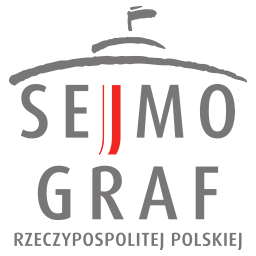


# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/SEJMograf /mydrive

# navigate to the working directory
%cd /mydrive

/content/gdrive/My Drive/Colab Notebooks/SEJMograf


## Libraries & functions
Let's now install missing libraries and import the necessary libraries and functions we're gonna use in this notebook.

- `numpy` - linear algebra
- `pandas` - data manipulation & analysis

In [3]:
import pandas as pd
import numpy as np
import plotly
import plotly.graph_objects as go

# Load data

In [4]:
df = pd.read_csv('df_clean.csv', index_col=0)
df.head()

,first_name,middle_name,last_name,gender,profile_url,picture,election_date,election_list,election_constituency,election_votes,oath_date,sejm_prl_term_IX,sejm_prl_term_X,sejm_term_I,sejm_term_II,sejm_term_III,sejm_term_IV,sejm_term_V,sejm_term_VI,sejm_term_VII,sejm_term_VIII,senat_term_IX,senat_term_X,senat_term_I,senat_term_II,senat_term_III,senat_term_IV,senat_term_V,senat_term_VI,senat_term_VII,senat_term_VIII,sejm_term_IX,club,birth_date,birth_place,education,school,title,graduation_year,occupation,...,coworker_33,coworker_33_function,coworker_33_info,coworker_34,coworker_34_function,coworker_34_info,coworker_35,coworker_35_function,coworker_35_info,coworker_36,coworker_36_function,coworker_36_info,coworker_37,coworker_37_function,coworker_37_info,coworker_38,coworker_38_function,coworker_38_info,asset_declarations,declaration_01,declaration_01_info,declaration_02,declaration_02_info,benefit_registers,benefit_register_01,benefit_register_01_info,benefit_register_02,benefit_register_02_info,benefit_register_03,benefit_register_03_info,benefit_register_04,benefit_register_04_info,benefit_register_05,benefit_register_05_info,benefit_register_06,benefit_register_06_info,benefit_register_07,benefit_register_07_info,benefit_register_08,benefit_register_08_info
0,Andrzej,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8A510...,2019-10-13,Prawo i Sprawiedliwość,Kraków,29686,2019-11-12,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Prawo i Sprawiedliwość,1959-01-04,Krzeszowice,wyższe,Społeczna Akademia Nauk w Łodzi,licencjat,2014.0,poseł,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/A324231DA1...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/549650FA05...,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,Rafał,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8ACA6...,2019-10-13,Sojusz Lewicy Demokratycznej,Katowice,12148,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,"Koalicyjny Klub Parlamentarny Lewicy (Razem, S...",1974-05-30,Dąbrowa Górnicza,wyższe,Politechnika Śląska,NaN,1999.0,samorządowiec,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/DB5AF9B44E...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FAE4951BE...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/EF53E6700...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Piotr,NaN,Adamowicz,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/3CA57...,2019-10-13,Koalicja Obywatelska,Gdańsk,41795,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Koalicja Obywatelska - Plat...,1961-06-26,Elbląg,średnie ogólne,VI LO Gdańsk,NaN,1980.0,dziennikarz/publicysta,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FF94DFF3A...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/2F249C8E3E...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/E7FACBAC8...,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Romuald,NaN,Ajchler,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/5E88F...,2019-10-13,Sojusz Lewicy Demokratycznej,Piła,14438,2019-11-12,False,False,False,True,True,True,False,True,True,False,False,False,False,False,False,False,

# Explore personal data

## First name

In [5]:
layout = go.Layout(
                   title=go.layout.Title(text='Most frequent first names'),
                   xaxis=go.layout.XAxis(title='Name'),
                   yaxis=go.layout.YAxis(title='Number of occurances')
                  )
fig = go.Figure(                
                go.Bar(
                       x=df['first_name'].value_counts().index[:10],
                       y=df['first_name'].value_counts().values[:10]
                      ),
                layout=layout    
               )
fig.show()

## Last name

In [6]:
layout = go.Layout(
                   title=go.layout.Title(text='Most frequent last names'),
                   xaxis=go.layout.XAxis(title='Last name'),
                   yaxis=go.layout.YAxis(title='Number of occurances')
                  )
fig = go.Figure(                
                go.Bar(
                       x=df['last_name'].value_counts().index[:10],
                       y=df['last_name'].value_counts().values[:10]
                      ),
                layout=layout    
               )
fig.show()

## Gender

In [7]:
df['election_list'].unique()

array(['Prawo i Sprawiedliwość', 'Sojusz Lewicy Demokratycznej',
       'Koalicja Obywatelska', 'Polskie Stronnictwo Ludowe',
       'Konfederacja Wolność i Niepodległość', 'Mniejszość Niemiecka'],
      dtype=object)

In [8]:
layout = go.Layout(
                   title=go.layout.Title(text='Most frequent names'),
                   xaxis=go.layout.XAxis(title='Last name'),
                   yaxis=go.layout.YAxis(title='Number of occurances')
                  )
list_of_parties = df['election_list'].unique()

def barGender(gender):
  df_cropped = df[df['gender'] == gender]
  if gender == 'm':
    name = 'man'
  else:
    name = 'woman'
  x = df_cropped['election_list'].value_counts().index
  y = df_cropped['election_list'].value_counts().values
  bar = go.Bar(
      name = name,
      x = x,
      y = y,
      text = y,
      textposition = 'inside',

  )
  return bar

layout = go.Layout(
                   title=go.layout.Title(text='Gender distribution in political parties'),
                   xaxis=go.layout.XAxis(title='Name of the party'),
                   yaxis=go.layout.YAxis(title='Number of representatives'),
                   barmode = 'stack'
                  )

fig = go.Figure(
    data=[barGender(gender) for gender in df['gender'].unique()],
    layout = layout
    )

fig.show()

# Explore political data

## Election list

In [9]:
labels = df['election_list'].value_counts().index
values = df['election_list'].value_counts().values

layout = go.Layout(
                   title=go.layout.Title(text='Number of representatives')
                  )

fig = go.Figure(                
                go.Pie(
                       labels = labels,
                       values = values,
                       text = labels
                      ),
                layout=layout    
               )
fig.show()

## Election constituency

In [10]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='FindLatLon')

location_coordinates = {
    city:(
        geolocator.geocode(city).latitude,
        geolocator.geocode(city).longitude
        ) for city in df['election_constituency'].unique()
    }

In [75]:
def findLatLon(name, dictionary):
  # solve errors
  if name == 'Sowieda':
    name = 'As-Suwajda'
  elif name == 'Siedliszczo':
    name = 'Siedliszcze'
  elif name == 'Kocierz Rydzwałdzki':
    name = 'Kocierz Rychwałdzki'
  elif name == 'Aalbore':
    name = 'Aalborg'
  elif name == 'Plimkaim':
    name = 'Plinkajmy'
    
  lat = dictionary[name][0]
  lon = dictionary[name][1]
  return lat, lon

In [11]:
def countPlace(name, column):
  number = len(df[df[column] == name])
  return number

In [12]:
locations = df['election_constituency']
lat = df['election_constituency'].apply(lambda x: findLatLon(x, location_coordinates)[0])
lon = df['election_constituency'].apply(lambda x: findLatLon(x, location_coordinates)[1])
sizes = df['election_constituency'].apply(lambda x: countPlace(x, 'election_constituency'))

mapbox_access_token = open('.mapbox_token').read()


layout = go.Layout(
                   title = go.layout.Title(text='Constituencies'),
                   mapbox=dict(
                       accesstoken = mapbox_access_token,
                       bearing = 0,
                       center = go.layout.mapbox.Center(
                           lat=52.1,
                           lon=19.3
                           ),
                       zoom = 4.5,
                       style = 'dark'
                       ),
                   width = 600,
                   height = 600
)

fig = go.Figure(                
                go.Scattermapbox(
                    lat = lat,
                    lon = lon,
                    mode = 'text+markers',
                    marker = go.scattermapbox.Marker(
                        size=sizes,
                        color='orange',
                        opacity=sizes/np.linalg.norm(sizes),
                        autocolorscale=True,
                        colorbar=None,
                        colorscale='viridis',
                        sizemode='diameter'                    
                        ),                  
                    text = locations,
                    textfont = go.scattermapbox.Textfont(
                        color = 'white',
                        size = 10),
                    textposition = 'bottom center'
                ),
                layout=layout    
               )
fig.show()

In [13]:
def extractCounty(name):
  address = geolocator.geocode(name).address.split(', ')
  for a in address:
    if a.startswith('województwo'):
      county = a
  return county

counties = {
    const:extractCounty(const) for const in df['election_constituency'].unique()
    }

df['election_constituency_county'] = df['election_constituency'].apply(lambda x: counties[x])

In [14]:
layout = go.Layout(
                   title=go.layout.Title(text='Geographical distribution of deputies'),
                   xaxis=go.layout.XAxis(title='County'),
                   yaxis=go.layout.YAxis(title='Number of representatives')
                  )
fig = go.Figure(                
                go.Bar(
                       x=df['election_constituency_county'].value_counts().index,
                       y=df['election_constituency_county'].value_counts().values
                      ),
                layout=layout    
               )
fig.show()

In [15]:
locations = df['election_constituency_county']

location_coordinates = {
    city:(
        geolocator.geocode(city).latitude,
        geolocator.geocode(city).longitude
        ) for city in df['election_constituency_county'].unique()
    }

lat = df['election_constituency_county'].apply(lambda x: findLatLon(x, location_coordinates)[0])
lon = df['election_constituency_county'].apply(lambda x: findLatLon(x, location_coordinates)[1])
sizes = df['election_constituency_county'].apply(lambda x: countPlace(x, 'election_constituency_county'))

mapbox_access_token = open('.mapbox_token').read()


layout = go.Layout(
                   title = go.layout.Title(text='Constituencies'),
                   mapbox=dict(
                       accesstoken = mapbox_access_token,
                       bearing = 0,
                       center = go.layout.mapbox.Center(
                           lat=52.1,
                           lon=19.3
                           ),
                       zoom = 4.5,
                       style = 'dark'
                       ),
                   width = 600,
                   height = 600
)

fig = go.Figure(                
                go.Scattermapbox(
                    lat = lat,
                    lon = lon,
                    mode = 'text+markers',
                    marker = go.scattermapbox.Marker(
                        size=sizes,
                        color='orange',
                        opacity=sizes/np.linalg.norm(sizes),
                        autocolorscale=True,
                        colorbar=None,
                        colorscale='viridis',
                        sizemode='diameter'                    
                        ),                  
                    text = locations,
                    textfont = go.scattermapbox.Textfont(
                        color = 'white',
                        size = 10),
                    textposition = 'bottom center'
                ),
                layout=layout    
               )
fig.show()

## Elecition votes

In [16]:
df_tmp = df.groupby('election_list').sum()['election_votes']
df_tmp

layout = go.Layout(
                   title=go.layout.Title(text='Cumulative number of votes'),
                   xaxis=go.layout.XAxis(title='Party'),
                   yaxis=go.layout.YAxis(title='Number of votes')
                  )
fig = go.Figure(                
                go.Bar(
                       x=df_tmp.index,
                       y=df_tmp.values,
                       text=(df_tmp.values/df_tmp.sum())*100, # calculate percentage
                       texttemplate='%{text:.2f}%', # format text output
                       textposition='inside' #text position
                      ),
                layout=layout    
               )
fig.show()

## Individual votes count

In [17]:
layout = go.Layout(
    title = go.layout.Title(text='Election votes'),
    xaxis=dict(
        title='Number of votes',
        # gridcolor='white',
        type='log',
        # gridwidth=2,
        ),
    yaxis=dict(
        title='Party name',
        # gridcolor='white',
        # gridwidth=2,
        )
)

fig = go.Figure(
    data = [
            go.Scatter(
                x=df['election_votes'],
                y=df['election_list'],
                mode='markers',
                text=df['first_name']+' '+df['last_name']
                )
            ],
    layout=layout 
            )

fig.show()

## Votes statistical representation


In [18]:
layout = go.Layout(
    title = go.layout.Title(text='Votes statistical representation'),
    xaxis=dict(
        title='Number of votes',
        type='log'
    )
)

fig = go.Figure(
    data = [
            go.Scatter(
                x=df[df['election_list']==l]['election_votes'],
                name=l,
                hovertext=l
            ) for l in df['election_list'].unique()
            ],
    layout=layout 
            )

fig.show()

## Service history

### Sejm

In [19]:
sejm_terms = [
    'sejm_prl_term_IX',
    'sejm_prl_term_X',
    'sejm_term_I',
    'sejm_term_II',
    'sejm_term_III',
    'sejm_term_IV',
    'sejm_term_V',
    'sejm_term_VI',
    'sejm_term_VII',
    'sejm_term_VIII',
    'sejm_term_IX'
]          

df_tmp = pd.Series(
    data=(df[df[term]==True].shape[0] for term in sejm_terms),
    index=sejm_terms
    )          	

data = [
        go.Bar(
            x=df_tmp.index,
            y=df_tmp.values,
            # xaxis=dict(
            #     title='Number of votes'
            #     )
            )
        ]

layout = go.Layout(
                   title=go.layout.Title(text='Service history'),
                   xaxis=go.layout.XAxis(title='Term name'),
                   yaxis=go.layout.YAxis(title='Number of representatives')
                  )
fig = go.Figure(                
                data=data,
                layout=layout    
               )
fig.show()

### Senat

In [20]:
senat_terms = [
    'senat_term_I',
    'senat_term_II',
    'senat_term_III',
    'senat_term_IV',
    'senat_term_V',
    'senat_term_VI',
    'senat_term_VII',
    'senat_term_VIII',
    'senat_term_IX',
    'senat_term_X',   
]   

df_tmp = pd.Series(
    data=(df[df[term]==True].shape[0] for term in senat_terms),
    index=senat_terms
    )          	

data = [
        go.Bar(
            x=df_tmp.index,
            y=df_tmp.values,
            # xaxis=dict(
            #     title='Number of votes'
            #     )
            )
        ]

layout = go.Layout(
                   title=go.layout.Title(text='Service history'),
                   xaxis=go.layout.XAxis(title='Term name'),
                   yaxis=go.layout.YAxis(title='Number of representatives')
                  )
fig = go.Figure(                
                data=data,
                layout=layout    
               )
fig.show()

In [21]:
# senat_terms = [
#     'senat_term_I',
#     'senat_term_II',
#     'senat_term_III',
#     'senat_term_IV',
#     'senat_term_V',
#     'senat_term_VI',
#     'senat_term_VII',
#     'senat_term_VIII',
#     'senat_term_IX',
#     'senat_term_X',   
# ]   


# def plotServiceHistory(terms):  
  
  
#   df_tmp = df[df.loc[:, 'election_list'] == 'Prawo i Sprawiedliwość']


#   data = [
#           go.Scatter(
#               # x=df[df.loc[:, 'election_list'] == party].index,
#               x=df
#               y=df[df.loc[:, 'election_list'] == party].values,
#               mode='lines',
#               name=party
#               # xaxis=dict(
#               #     title='Number of votes'
#               #     )
#               )
#           for party in df['election_list'].unique()]

#   layout = go.Layout(
#                     title=go.layout.Title(text='Service history'),
#                     xaxis=go.layout.XAxis(title='Term name'),
#                     yaxis=go.layout.YAxis(title='Number of representatives')
#                     )
#   fig = go.Figure(                
#                   data=data,
#                   layout=layout    
#                 )
#   fig.show()


# plotServiceHistory(senat_terms)


# # fig = go.Figure()
# # fig.add_trace(
# #     go.Scatter(
# #         x=df_tmp.index,
# #         y=df_tmp.values,
# #         mode='lines',
# #         name='lines'
# #         )
# #     )




# # fig.add_trace(go.Scatter(x=random_x, y=random_y1,
# #                     mode='lines+markers',
# #                     name='lines+markers'))
# # fig.add_trace(go.Scatter(x=random_x, y=random_y2,
# #                     mode='markers', name='markers'))

# # fig.show()

In [22]:
term_dict = {}

for party in df['election_list'].unique():
  df_tmp = df[df.loc[:, 'election_list'] == party]
  term_list = pd.Series(
      data=(df_tmp[df_tmp[term]==True].shape[0] for term in sejm_terms),
      index=sejm_terms
      )  
  term_dict[party] = term_list

df_terms_sejm = pd.DataFrame(term_dict)
df_terms_sejm

,Prawo i Sprawiedliwość,Sojusz Lewicy Demokratycznej,Koalicja Obywatelska,Polskie Stronnictwo Ludowe,Konfederacja Wolność i Niepodległość,Mniejszość Niemiecka
sejm_prl_term_IX,0,0,1,0,0,0
sejm_prl_term_X,0,0,1,1,0,0
sejm_term_I,3,0,3,0,1,0
sejm_term_II,0,4,2,3,0,0
sejm_term_III,9,4,5,3,0,0
sejm_term_IV,14,5,11,5,0,0
sejm_term_V,55,4,33,7,1,1
sejm_term_VI,69,5,50,7,0,1
sejm_term_VII,79,7,66,8,0,1
sejm_term_VIII,172,1,90,18,2,1


In [23]:
term_dict = {}

for party in df['election_list'].unique():
  df_tmp = df[df.loc[:, 'election_list'] == party]
  term_list = pd.Series(
      data=(df_tmp[df_tmp[term]==True].shape[0] for term in senat_terms),
      index=senat_terms
      )  
  term_dict[party] = term_list

df_terms_senat = pd.DataFrame(term_dict)
df_terms_senat

,Prawo i Sprawiedliwość,Sojusz Lewicy Demokratycznej,Koalicja Obywatelska,Polskie Stronnictwo Ludowe,Konfederacja Wolność i Niepodległość,Mniejszość Niemiecka
senat_term_I,1,0,0,0,0,0
senat_term_II,0,0,0,0,0,0
senat_term_III,0,0,0,0,0,0
senat_term_IV,2,0,0,0,0,0
senat_term_V,0,0,1,0,0,0
senat_term_VI,2,0,4,0,0,0
senat_term_VII,2,0,3,0,0,0
senat_term_VIII,2,0,2,0,0,0
senat_term_IX,1,0,3,0,0,0
senat_term_X,0,0,0,0,0,0


In [24]:
data = [
        go.Scatter(
            x=df_terms_sejm[party].index,
            y=df_terms_sejm[party].values,
            name=party,
            mode='lines+markers'
            ) for party in df['election_list'].unique()
        ]


layout = go.Layout(
                   title=go.layout.Title(text='Service history'),
                   xaxis=go.layout.XAxis(title='Term name'),
                   yaxis=go.layout.YAxis(title='Number of representatives')
                  )
fig = go.Figure(                
                data=data,
                layout=layout    
               )
fig.show()

In [25]:
data = [
        go.Scatter(
            x=df_terms_senat[party].index,
            y=df_terms_senat[party].values,
            mode='lines+markers',
            name=party
            ) for party in df['election_list'].unique()
        ]


layout = go.Layout(
                   title=go.layout.Title(text='Service history'),
                   xaxis=go.layout.XAxis(title='Term name'),
                   yaxis=go.layout.YAxis(title='Number of representatives')
                  )
fig = go.Figure(                
                data=data,
                layout=layout    
               )
fig.show()

## Club transfers

In [26]:
df['club'].unique()

array(['Klub Parlamentarny Prawo i Sprawiedliwość',
       'Koalicyjny Klub Parlamentarny Lewicy (Razem, Sojusz Lewicy Demokratycznej, Wiosna Roberta Biedronia)',
       'Klub Parlamentarny Koalicja Obywatelska - Platforma Obywatelska, Nowoczesna, Inicjatywa Polska, Zieloni',
       'Klub Parlamentarny Koalicja Polska - PSL, UED, Konserwatyści',
       'Koło Poselskie Konfederacja', 'Poseł niezrzeszony'], dtype=object)

## Birth date

In [27]:
import datetime
from dateutil.relativedelta import relativedelta

def calculateAge(date):
  today = datetime.date.today()
  birthdate = datetime.datetime.strptime(date, '%Y-%m-%d').date()

  age = relativedelta(today, birthdate)
  age = age.years



  return age

df['age'] = df['birth_date'].apply(lambda x: calculateAge(x))
df.head()


,first_name,middle_name,last_name,gender,profile_url,picture,election_date,election_list,election_constituency,election_votes,oath_date,sejm_prl_term_IX,sejm_prl_term_X,sejm_term_I,sejm_term_II,sejm_term_III,sejm_term_IV,sejm_term_V,sejm_term_VI,sejm_term_VII,sejm_term_VIII,senat_term_IX,senat_term_X,senat_term_I,senat_term_II,senat_term_III,senat_term_IV,senat_term_V,senat_term_VI,senat_term_VII,senat_term_VIII,sejm_term_IX,club,birth_date,birth_place,education,school,title,graduation_year,occupation,...,coworker_33_info,coworker_34,coworker_34_function,coworker_34_info,coworker_35,coworker_35_function,coworker_35_info,coworker_36,coworker_36_function,coworker_36_info,coworker_37,coworker_37_function,coworker_37_info,coworker_38,coworker_38_function,coworker_38_info,asset_declarations,declaration_01,declaration_01_info,declaration_02,declaration_02_info,benefit_registers,benefit_register_01,benefit_register_01_info,benefit_register_02,benefit_register_02_info,benefit_register_03,benefit_register_03_info,benefit_register_04,benefit_register_04_info,benefit_register_05,benefit_register_05_info,benefit_register_06,benefit_register_06_info,benefit_register_07,benefit_register_07_info,benefit_register_08,benefit_register_08_info,election_constituency_county,age
0,Andrzej,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8A510...,2019-10-13,Prawo i Sprawiedliwość,Kraków,29686,2019-11-12,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Prawo i Sprawiedliwość,1959-01-04,Krzeszowice,wyższe,Społeczna Akademia Nauk w Łodzi,licencjat,2014.0,poseł,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/A324231DA1...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/549650FA05...,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,województwo małopolskie,62
1,Rafał,NaN,Adamczyk,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8ACA6...,2019-10-13,Sojusz Lewicy Demokratycznej,Katowice,12148,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,"Koalicyjny Klub Parlamentarny Lewicy (Razem, S...",1974-05-30,Dąbrowa Górnicza,wyższe,Politechnika Śląska,NaN,1999.0,samorządowiec,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/DB5AF9B44E...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FAE4951BE...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/EF53E6700...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,województwo śląskie,46
2,Piotr,NaN,Adamowicz,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/3CA57...,2019-10-13,Koalicja Obywatelska,Gdańsk,41795,2019-11-12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,Klub Parlamentarny Koalicja Obywatelska - Plat...,1961-06-26,Elbląg,średnie ogólne,VI LO Gdańsk,NaN,1980.0,dziennikarz/publicysta,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,Początek kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/9FF94DFF3A...,I rok kadencji,https://orka.sejm.gov.pl/osw9.nsf/0/2F249C8E3E...,1,2020-01-09,https://orka.sejm.gov.pl/rkor9.nsf/0/E7FACBAC8...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,województwo pomorskie,59
3,Romuald,NaN,Ajchler,m,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/5E88F...,2019-10-13,Sojusz Lewicy Demokratycznej,Piła,14438,2019-11-12,False,False,False,True,True,True,False,True,True,Fal

In [47]:
layout = go.Layout(
    title = go.layout.Title(text='Age of the representatives'),
    height=700,
    xaxis=dict(
        title='Age',
        # type='log'
    )
)

fig = go.Figure(
    data = [
            go.Box(
                x=df[df['election_list']==l]['age'],
                name=l,
                hovertext=df[df['election_list']==l]['first_name']+' '+df[df['election_list']==l]['last_name'],
                boxpoints='all',
                jitter=0.5,
                pointpos=-2,

            ) for l in df['election_list'].unique()
            ],
    layout=layout 
            )

fig.show()

## Birth place

In [72]:
#initiate coordinates container
birthplace_coordinates = {}

# iterate through unique cities
for city in df['birth_place'].unique():
  # solve errors
  if city == 'Sowieda':
    city = 'As-Suwajda'
  elif city == 'Siedliszczo':
    city = 'Siedliszcze'
  elif city == 'Kocierz Rydzwałdzki':
    city = 'Kocierz Rychwałdzki'
  elif city == 'Aalbore':
    city = 'Aalborg'
  elif city == 'Plimkaim':
    city = 'Plinkajmy'

  # append latitude & longitude to the dictionary
  birthplace_coordinates[city] = (
      geolocator.geocode(city).latitude,
      geolocator.geocode(city).longitude
      )

In [76]:
locations = df['birth_place']
lat = df['birth_place'].apply(lambda x: findLatLon(x, birthplace_coordinates)[0])
lon = df['birth_place'].apply(lambda x: findLatLon(x, birthplace_coordinates)[1])
sizes = df['birth_place'].apply(lambda x: countPlace(x, 'birth_place'))

mapbox_access_token = open('.mapbox_token').read()


layout = go.Layout(
                   title = go.layout.Title(text='Birth places'),
                   mapbox=dict(
                       accesstoken = mapbox_access_token,
                       bearing = 0,
                       center = go.layout.mapbox.Center(
                           lat=52.1,
                           lon=19.3
                           ),
                       zoom = 4.5,
                       style = 'dark'
                       ),
                   width = 600,
                   height = 600
)

fig = go.Figure(                
                go.Scattermapbox(
                    lat = lat,
                    lon = lon,
                    mode = 'text+markers',
                    marker = go.scattermapbox.Marker(
                        size=sizes,
                        color='orange',
                        opacity=sizes/np.linalg.norm(sizes),
                        autocolorscale=True,
                        colorbar=None,
                        colorscale='viridis',
                        sizemode='diameter'                    
                        ),                  
                    text = locations,
                    textfont = go.scattermapbox.Textfont(
                        color = 'white',
                        size = 10),
                    textposition = 'bottom center'
                ),
                layout=layout    
               )
fig.show()

In [29]:
# https://towardsdatascience.com/geocode-with-python-161ec1e62b89
# https://holypython.com/how-to-create-map-charts-in-python-w-plotly-mapbox/


transfery pomiędzy partiami

SyntaxError: ignored